## This notebook works on Word Embeddings using Keras (Fine tune learned embeddings)

## This uses the Glove Model

### Import the libraries and define the arguments

In [11]:
# import the necessary libraries
from keras.layers.core import Dense, Activation, Dropout, SpatialDropout1D 
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

# adding the import from gensim implementation of word2vec
from gensim.models import word2vec
from gensim.models import KeyedVectors

import nltk
import collections
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
%matplotlib inline

np.random.seed(42)

INPUT_FILE = "/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/umich_sentiment_dataset/train.txt"
GLOVE_WEIGHTS = "/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/glove_pretrained_weights/glove.6B.300d.txt"
VOCAB_SIZE = 5000
EMBEDDING_SIZE = 300
NUM_FILTERS=256
NUM_WORDS = 3
BATCH_SIZE = 64
NUM_EPOCHS = 20    # reduced the number of epochs to 10 as convergence is reached on using pre-trained weights
DROPOUT_RATE = float(0.2)

### Learn Embeddings using Fine Tuning pre-trained weights

In [2]:
# create our vocablary of most frequent words from the corpus
counter = collections.Counter()
fin = open(INPUT_FILE, 'r')
maxlen = 0
i = 0
for line in fin:
    sent = line.strip().split("\t")[1]
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1
fin.close()

# create the word indexes and the reverse indexes for the words
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid +1
vocab_size = len(word2index) + 1
index2word = {v:k for k,v in word2index.items()}
print(len(word2index))
print("")
print(word2index)
# print(index2word)

2329

defaultdict(<class 'int'>, {"'ll": 363, 'long': 416, 'allegory': 2166, 'lynn': 970, 'mother': 448, 'fireworks': 649, 'entire': 971, 'how': 72, 'seems': 972, 'sucks': 29, 'be': 45, 'briefly': 1422, 'gossip': 1598, 'ever': 135, "saying'harry": 974, 'independent': 1862, 'predictability': 2242, 'requiem': 975, 'movie..': 417, 'best': 337, 'meganpenworthy': 2071, 'worst': 977, 'use': 652, 'combonation': 980, 'suspenseful': 981, 'jail': 982, 'jenn': 983, 'from': 121, 'finished': 423, 'oceans': 1424, 'earrings': 1944, 'went': 107, 'fell': 484, 'figured': 1864, 'vault': 1365, 'scientology': 986, 'heard': 133, 'everything': 653, 'nc-17': 647, 'gay': 151, 'richard': 988, 'sounds': 654, 'believably': 1141, 'hill': 227, 'irrespective': 989, 'low': 990, 'out': 52, 'politics': 809, 'yip': 2117, 'beautiful..': 655, 'selfish': 991, 'end': 449, 'amazes': 993, 'cowboys': 418, 'cute': 656, 'sold': 994, 'save': 995, 'comprehend': 996, '2..': 997, '?': 148, 'captain': 657, 'soooo': 998, 'messiah': 17

### Now pad the sentences to the maxlength and create the dataset for splitting

In [3]:
xs , ys = [], []
fin = open(INPUT_FILE, "r")
for line in fin:
    label, sent = line.strip().split("\t")
    ys.append(int(label))
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    wids = [word2index[word] for word in words]
    xs.append(wids)
fin.close()
X = pad_sequences(xs, maxlen=maxlen)
Y = np_utils.to_categorical(ys)

### Split the X and y to train and validation set using sklearn 

In [37]:
#print(maxlen) # 42 in this case
# print(X.shape) # (7086 , 42) is the shape
# print(Y.shape)  # (7086, 2) is the shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)
print(X_train.shape," ", X_test.shape," ", Y_train.shape, " ", Y_test.shape)
print(X_train[0].shape)
print(X_train[0])

(4960, 42)   (2126, 42)   (4960, 2)   (2126, 2)
(42,)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   7  13  16  21   1 108  65 199
  73 173 174 254   6  91]


### Load the glove model trained weights

In [7]:
# read the glove model weights from the file
glove = {}
fin = open(GLOVE_WEIGHTS, "r")
for line in fin:
    cols = line.strip().split(" ")
    word = cols[0]
    vec = cols[1:]
    glove[word] = vec
fin.close
    
embedding_weights = np.zeros((vocab_size, EMBEDDING_SIZE))
for word, index in word2index.items():
    try:
        embedding_weights[index:] = glove[word]
    except KeyError:
        pass

### Now define the model and compile the model and fit the model on the train data

In [8]:
embedding_weights.shape

(2330, 300)

In [9]:
model = Sequential()
# the difference is to initialize the embedding weight matrix with pretrained weights
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=maxlen, weights=[embedding_weights]))  
model.add(SpatialDropout1D(DROPOUT_RATE))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 42, 300)           699000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 42, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 256)           230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 930,170
Trainable params: 930,170
Non-trainable params: 0
_________________________________________________________________


In [12]:
# have the model compile and fit on the training data

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, Y_test))

Train on 4960 samples, validate on 2126 samples
Epoch 1/20
4960/4960 [==============================] - 8s - loss: 0.0081 - acc: 0.9980 - val_loss: 0.0376 - val_acc: 0.9868
Epoch 2/20
4960/4960 [==============================] - 9s - loss: 0.0036 - acc: 0.9992 - val_loss: 0.0877 - val_acc: 0.9802
Epoch 3/20
4960/4960 [==============================] - 9s - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0384 - val_acc: 0.9882
Epoch 4/20
4960/4960 [==============================] - 9s - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0403 - val_acc: 0.9868
Epoch 5/20
4960/4960 [==============================] - 9s - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0781 - val_acc: 0.9831
Epoch 6/20
4960/4960 [==============================] - 9s - loss: 0.0047 - acc: 0.9994 - val_loss: 0.0498 - val_acc: 0.9887
Epoch 7/20
4960/4960 [==============================] - 10s - loss: 0.0067 - acc: 0.9984 - val_loss: 0.1356 - val_acc: 0.9722
Epoch 8/20
4960/4960 [==============================] - 9s - loss: 0.0043 - 

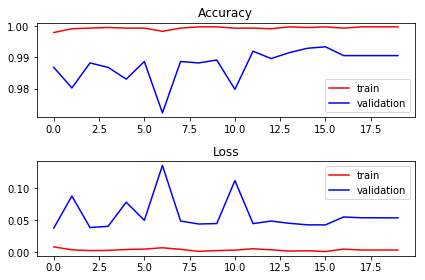

In [13]:
#plot loss function

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [14]:
# check the accuracy and the loss on the test set
score = model.evaluate(X_test, Y_test, verbose=1)
print(score)

2048/2126 [===========================>..] - ETA: 0s[0.053514744588955443, 0.99059266227657572]


### Look up embeddings and use them for training a simple network (need not have Embedding layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 42, 300)           699000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 42, 300)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 256)           230656    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 930,170
Trainable params: 231,170
Non-trainable params: 699,000
_________________________________________________________________
Train on 4960 samples, validate on 2126 samples
Epoch 1/20
4960/4960 [==============================] - 5s - loss: 0.3378 - acc: 0

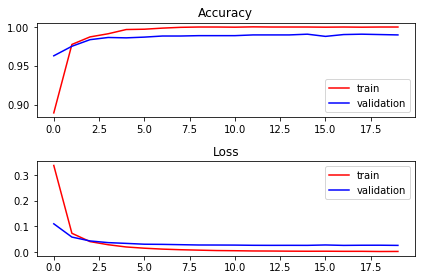

2080/2126 [============================>.] - ETA: 0s[0.025359562777172464, 0.98965192850423334]


In [15]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=maxlen, trainable=False))
model.add(SpatialDropout1D(DROPOUT_RATE))
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, Y_test))

#plot loss function

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# check the accuracy and the loss on the test set
score = model.evaluate(X_test, Y_test, verbose=1)
print(score)

##  Use Existing Model weights for downstream jobs

### Ideal way is to use a network to train on the sentences which comprise of words represented by embedded vectors

In [32]:
# import the necessary libraries
from keras.layers.core import Dense, Activation, Dropout, SpatialDropout1D 
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import nltk
import collections
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
%matplotlib inline

np.random.seed(42)

INPUT_FILE = "/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/umich_sentiment_dataset/train.txt"
GLOVE_WEIGHTS = "/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/glove_pretrained_weights/glove.6B.100d.txt"
VOCAB_SIZE = 5000
EMBEDDING_SIZE = 100
BATCH_SIZE = 64
NUM_EPOCHS = 20    # reduced the number of epochs to 10 as convergence is reached on using pre-trained weights
DROPOUT_RATE = float(0.2)

### Pre-processing the data

In [7]:
counter = collections.Counter()
fin = open(INPUT_FILE, "r")
maxlen = 0
for line in fin:
    _, sent = line.strip().split("\t")
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1
fin.close()

word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}
index2word[0] = "_UNK_"

ws, ys = [], []
fin = open(INPUT_FILE, "r")
for line in fin:
    label, sent = line.strip().split("\t")
    ys.append(int(label))
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    wids = [word2index[word] for word in words]
    ws.append(wids)
fin.close()
W = pad_sequences(ws, maxlen=maxlen)
Y = np_utils.to_categorical(ys)

#print some of the values to see the shapes

print(len(ws))
print(len(ys))
print(ws[0])

7086
7086
[4, 9, 8, 11, 100, 16, 47, 21, 3]


In [8]:
# read the glove matrix
word2emb = collections.defaultdict(int)
fglove = open(GLOVE_WEIGHTS, "r")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    embedding = np.array(cols[1:], dtype="float32")
    word2emb[word] = embedding
fglove.close()

In [9]:
# get some shapes and definitions
print(W.shape)
print(Y.shape)
print(len(word2index))
print(len(index2word))
print(len(word2emb))
print(W[0])

(7086, 42)
(7086, 2)
2329
2330
400000
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   4   9   8
  11 100  16  47  21   3]


### The main difference from finetuning comes is unlike the Xs values earlier this one is a sum of all the embedding vectors of all the words in a sentence.

In [35]:
X = np.zeros((W.shape[0], EMBEDDING_SIZE))  # X becomes the size of (7086, 100)
print(X.shape)
for i in range(W.shape[0]):
    E = np.zeros((EMBEDDING_SIZE, maxlen)) #create E of size (100, 42)
    words = [index2word[wid] for wid in W[i].tolist()] # takes all words in the sentence, 
    # and find the words for each sentence using reverse look up
    for j in range(maxlen):
        E[:, j] = word2emb[words[j]] # take each word , find their embedding vector and store them in E the E 
        # matrix each time becomes (100, 42), where each of the 42 words are across the columns and 
        # their embedding is along the rows hence 100 dimensions
    X[i, :] = np.sum(E, axis=1) # their dimension is summed across the each row of E and stored as columns for X[i]
    
print(X[0])

(7086, 100)
[ -1.24347695e+00   5.08375943e-01   4.92231204e+00  -3.76738004e+00
  -1.76537991e-01   2.30248503e+00  -9.28863987e-01   1.53060600e+00
   1.26434704e+00   7.79104803e-01   3.52949828e+00  -2.08607800e+00
  -2.97674984e-01  -1.33459486e+00  -8.02809013e-01  -8.20379049e-01
   5.39411007e+00   3.14392095e+00  -1.14233993e+00   2.75312898e+00
   2.17714198e+00  -1.38604999e+00   6.56086009e-01   8.94033048e-01
   4.34669995e+00  -4.07906026e-01   3.19723967e-01  -2.74574200e+00
  -1.27148001e+00  -3.19357399e+00  -3.03219204e+00   2.85512497e+00
   1.80100000e+00   1.66936905e+00   6.77399337e-03   3.14154308e+00
  -6.09675830e-01   8.92780021e-01   1.36755999e+00  -1.11206987e+00
  -2.39340001e+00  -7.38759995e-01   1.84707001e+00  -1.55454598e+00
  -1.35417000e+00  -2.14625001e-01   1.13979100e+00  -2.28497394e+00
  -8.48060185e-02  -1.81376990e+00   2.78932301e-01   3.80266994e-01
   5.76315954e-01   7.80608998e+00  -6.64653996e+00  -1.92733998e+01
  -8.54929997e-01   1.

### Divide the data into train and test, define the model and train the model

Train on 4960 samples, validate on 2126 samples
Epoch 1/20
4960/4960 [==============================] - 0s - loss: 1.1088 - acc: 0.6194 - val_loss: 0.4669 - val_acc: 0.8039
Epoch 2/20
4960/4960 [==============================] - 0s - loss: 0.4074 - acc: 0.8419 - val_loss: 0.3105 - val_acc: 0.9323
Epoch 3/20
4960/4960 [==============================] - 0s - loss: 0.2759 - acc: 0.9087 - val_loss: 0.2285 - val_acc: 0.9459
Epoch 4/20
4960/4960 [==============================] - 0s - loss: 0.2123 - acc: 0.9361 - val_loss: 0.1846 - val_acc: 0.9605
Epoch 5/20
4960/4960 [==============================] - 0s - loss: 0.1789 - acc: 0.9478 - val_loss: 0.1538 - val_acc: 0.9643
Epoch 6/20
4960/4960 [==============================] - 0s - loss: 0.1475 - acc: 0.9589 - val_loss: 0.1417 - val_acc: 0.9591
Epoch 7/20
4960/4960 [==============================] - 0s - loss: 0.1354 - acc: 0.9609 - val_loss: 0.1317 - val_acc: 0.9591
Epoch 8/20
4960/4960 [==============================] - 0s - loss: 0.1152 - a

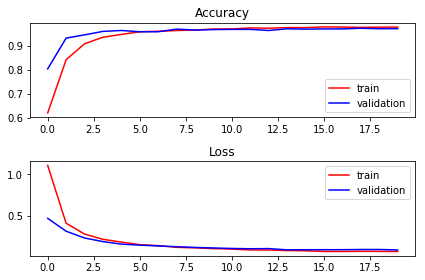

  32/2126 [..............................] - ETA: 0sTest score: 0.083, accuracy: 0.972


In [33]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=42)

model = Sequential()
model.add(Dense(32, input_dim=100, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(Xtest, Ytest))

#plot loss function

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()


score = model.evaluate(Xtest, Ytest, verbose=1)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

#### Debug shapes

In [30]:
# temporary testing of the block by 1 row at a time

words = [index2word[wid] for wid in W[0].tolist()]
print(words)
E = np.zeros((EMBEDDING_SIZE, maxlen))
print(E.shape)
E[:, 0] = word2emb[words[0]]

print("")
abc = np.matrix([[1,2], [3,4]])
print(abc)
print("")
print(np.sum(abc, axis=0))
print("")
print(np.sum(abc, axis=1))


['_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', '_UNK_', 'the', 'da', 'vinci', 'code', 'book', 'is', 'just', 'awesome', '.']
(100, 42)

[[1 2]
 [3 4]]

[[4 6]]

[[3]
 [7]]
